In [1]:
from IPython.display import Video, Image, HTML
import jax
import jax.numpy as jnp
import numpy as np
import scipy
import gzip
import pickle
import matplotlib
import matplotlib.pyplot as plt
from celluloid import Camera

##### Clustering, Metric Learning and PAC introduction.

### David Picard 
### École des Ponts ParisTech
### david.picard@enpc.fr

# Unsupervised learning

What if we don't have labels?


- Training set $\mathcal{A} = \{\mathbf{x}\}$

What if we don't even have any idea about the structure of $\mathcal{Y}$?

- Density estimation (how likely is $\mathbf{x}$)
- Clustering (partition $\mathcal{X}$ into exclusive classes)

## Density estimation

Given a training set of samples $\mathcal{A} = \{\mathbf{x}\}$, we want to model a probability density function $f(\mathbf{x})$ corresponding to the distribution $D$ such that $\mathbf{x} \sim D$

- $f$ has to be a pdf:

  - $\forall \mathbf{x}\in\mathcal{X}, f(\mathbf{x})\geq 0$
  
  - $\int_\mathcal{X} f(\mathbf{x})d\mathbf{x} = 1$
  



Useful for anomaly detection, e.g., if $f(\mathbf{x}) \leq \theta$ (Also called *Out of Distribution* detection)



- Simple pdf model, ex

$$ f(\mathbf{x}) = \frac{1}{\sqrt{2\pi}\sigma}e^{\frac{\|\mathbf{x} - \mu \|^2}{2\sigma^2}} $$



We have observations, they are likely by definition


Maximizing the probability of $\mathcal{A}$

$$ \max_f Pr[\mathcal{A}] = \prod_{\mathbf{x}_i}  f(\mathbf{x}_i) $$



Equivalently, maximizing the log probability

$$ \max_f Pr[\mathcal{A}] = \sum_{\mathbf{x}_i} \log f(\mathbf{x}_i) $$

For the Gaussian

$$ \sum_{\mathbf{x}_i} \log f(\mathbf{x}_i) = \sum_{\mathbf{x}_i} -\|\mathbf{x}_i - \mu \|^2 / 2\sigma^2 - n\log\sqrt{2\pi} \sigma$$

The maximimzation is equivalent to 

$$ \min_\mu \sum_{\mathbf{x}_i} \| \mathbf{x}_i - \mu \|^2 $$

Which is attained for 

\begin{align}
\frac{\partial \sum_{\mathbf{x}_i} \|\mathbf{x}_i - \mu \|^2}{\partial \mu} &= 0\\
2n\mu - 2\sum_{\mathbf{x}_i}\mathbf{x}_i &= 0 \\
\mu &= \frac{1}{n} \sum_{\mathbf{x}_i} \mathbf{x}_i
\end{align}

For $\sigma$

$$\min_\sigma \sum_{\mathbf{x}_i} \|\mathbf{x}_i - \mu \|^2 / 2\sigma^2 + n\log\sqrt{2\pi} \sigma $$

\begin{align}
\frac{\partial \sum_{\mathbf{x}_i} \|\mathbf{x}_i - \mu \|^2 / 2\sigma^2 + n\log\sqrt{2\pi} \sigma }{\partial \sigma} &= 0 \\
 - \frac{\sum_{\mathbf{x}_i} \|\mathbf{x}_i - \mu \|^2}{\sigma^3} + \frac{n}{\sigma} &=0 \\
 \sigma^2 &= \frac{\sum_{\mathbf{x}_i} \|\mathbf{x}_i - \mu \|^2}{n}
\end{align}

## Expectation-Maximization

Some pdf models do not lead to closed form solution (case of mixture models)



Alternate optimisation scheme


Initialize model parameters $\Gamma_0$


- Expectation step: Assumming parameters $\Gamma_t$, compute *expected* likelihood (or log-likelihood) of $f$ w.r.t. $\mathcal{A}$


- Maximization step: Maximize this expected likelihood of $f$ w.r.t. $\Gamma$



## Gaussian Mixture model

$$ f(\mathbf{x}) = \sum_k \pi_k e^{ (\mathbf{x}-\mu_k)^\top \Gamma_k (\mathbf{x}-\mu_k)}$$

$\pi_k$ is the weight (population) , $\mu_k$ the mean and $\Gamma_k$ is the inverse covariance matrix of component $k$



An observation $\mathbf{x}$ belongs to component $k$ with likelihood $f_k(\mathbf{x})$

E step

$$ E[\log f(\mathbf{x}_i)] = \sum_k Pr[k|\mathbf{x}_i]\log f_k(\mathbf{x}_i)] $$

With

$$ Pr[k|\mathbf{x}_i] = h_i^k = \frac{\pi_k e^{(\mathbf{x}_i - \mu_k)^\top\Gamma_k(\mathbf{x}_i - \mu_k)}}{\sum_j\pi_j e^{(\mathbf{x}_i - \mu_j)^\top\Gamma_j(\mathbf{x}_i - \mu_j)}} $$

M step:

$$ \max_{\pi, \mu, \Gamma} E[\log f(\mathbf{x})] = \sum_i \sum_k h_i^k \log f_k(\mathbf{x}_i) $$

\begin{align}
\pi_k &= \frac{\sum_i h_i^k}{n} \\
\mu_k &= \frac{\sum_i h_i^k \mathbf{x}_i}{\sum_i h_i^k}\\
\Gamma_k^{-1} &= \frac{\sum_i h_i^k (\mathbf{x}_i - \mu_k)(\mathbf{x}_i-\mu_k)^\top}{\sum_i h_i^k}
\end{align}

In [2]:
from sklearn.datasets import make_moons

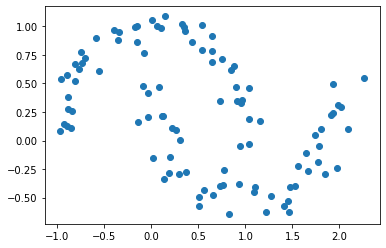

In [3]:
X, y = make_moons(100, noise=0.1)
plt.scatter(X[:,0], X[:,1])

In [166]:
def Estep(X, w, mu, s):
    xmu = X[:, None, :] - mu[None, :, :] # n x 5 x 2
    sxm = xmu/(1e-7+s[None,:,:]) # n x 5 x 2
    xmsxm = w * jnp.exp(-(xmu * sxm).sum(2)) # n x 5
    return xmsxm

def Mstep(X, h):
    w = h.mean(axis=0)
    m = (h[:,:,None]*X[:,None,:]).sum(axis=0) / h.sum(axis=0)[:,None] # 5 x 2
    xm = X[:,None,:] - m[None,:,:] # n x 5 x 2
    s = (h[:,:,None]*xm*xm).sum(axis=0) / h.sum(axis=0)[:,None] # 5 x 2
    return w, m, s

In [199]:
np.random.seed(4)
w = np.ones(5)/5.
m = 0.5*np.random.randn(5, 2)+0.5
s = 0.5*jnp.ones((5,2))

In [211]:
def plot_density(X, w, m, s):
    t = 50; tx = jnp.linspace(-2, 3, t); ty = jnp.linspace(-2, 2, t)
    xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
    xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
    y_pred = jnp.array(Estep(xx,w,m,s)).sum(axis=1).reshape(t, t)
    plt.contourf(xv, yv, y_pred, cmap='coolwarm')
    cs = plt.contour(xv, yv, y_pred, colors='k')
    plt.clabel(cs, inline=True)
    plt.scatter(X[:,0], X[:,1], c=0*jnp.ones(len(X)))
    plt.scatter(m[:,0], m[:,1], c=1+jnp.arange(len(m)), marker='^', s=150*(1+s.sum(axis=1)), edgecolors='k')

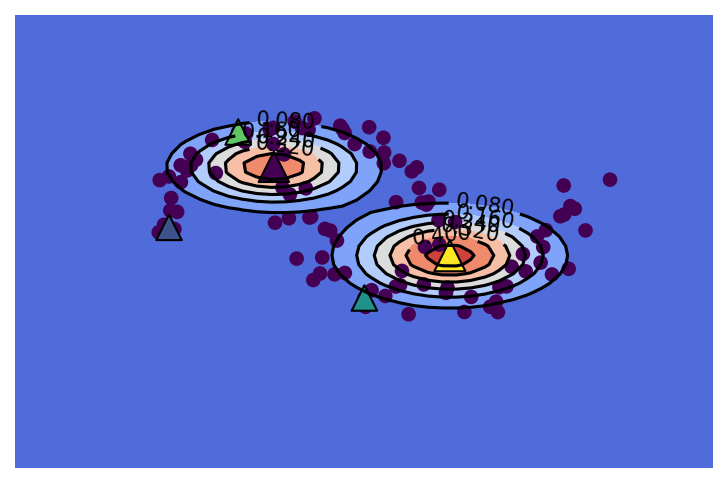

In [201]:
fig = plt.figure(dpi=150)
plt.axis('off')
camera = Camera(fig)
for i in range(50):
    plot_density(X, w, m, s)
    h = Estep(X, w, m, s)
    h = h / (1e-4+h.sum(axis=1, keepdims=True))
    w, m, s = Mstep(X, h)
    plt.axis([-2, 3, -2, 2])
    camera.snap()
        
animation = camera.animate()
HTML(animation.to_html5_video())  

## One class SVM

Given a training set $\mathcal{A} = \{\mathbf{x}_i\}$ and a kernel $k(\cdot, \cdot) = \langle \phi(\cdot), \phi(\cdot) \rangle$, we want to find a classifier of high density regions:

$$ \min_{\mathbf{w}, \xi, \rho} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_i \xi_i - \rho\\ \text{ s.t. } \forall i, \langle \mathbf{w}, \phi(\mathbf{x}_i) \rangle \geq \rho - \xi_i\\ \forall i, \xi_i \geq 0  $$

Using KKT:

\begin{align}
\mathbf{w} &= \sum_i \alpha_i \phi(\mathbf{x}_i)\\
\sum_i\alpha_i &= 1\\
0 &\leq \alpha_i \leq C
\end{align}

#### Dual problem:

$$\max_{\alpha} \frac{1}{2} \sum_{ij} \alpha_i\alpha_j k(\mathbf{x}_i,\mathbf{x}_j)\\
\text{s.t. } \forall i,  0 \leq \alpha_i \leq C \\ \sum_i \alpha_i = 1 $$ 

Solved using any QP solver (or projected coordinate ascent)

Recovering $\rho$

KKT, complementary slackness:

$$ \forall i, \lambda_i(\rho - \xi_i - \sum_{ij}\alpha_jk(\mathbf{x}_i, \mathbf{x}_j)) = 0 $$



if $\alpha_i \neq 0$ and $\alpha_i \neq C$

$$\xi_i = 0$$

and 

$$ \lambda_i \neq 0 $$

Thus
$$\rho = \sum_j \alpha_j k(\mathbf{x}_i, \mathbf{x}_j) $$

In [279]:
def gauss_kernel(X1, X2, gamma=5.):
    D = (X1[:,None,:] - X2[None,:,:])**2
    return jnp.exp(-gamma*D.sum(axis=2))

In [280]:
def loss(alpha, X):
    K = gauss_kernel(X, X)
    return 0.5 * (alpha[None,:] @ (K @ alpha[:,None])).squeeze()

In [293]:
@jax.jit
def update(alpha, X, C = 1., eta=0.1):
    da = jax.grad(loss, argnums=0)(alpha, X)
    a = jnp.clip(alpha + eta*da, 0, C)
    return a/a.sum()    

In [294]:
t = 50; tx = jnp.linspace(-2, 3, t); ty = jnp.linspace(-2, 2, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])

In [308]:
def plot_density(X, xx, y_pred):
    plt.contourf(xv, yv, y_pred, cmap='coolwarm')
    cs = plt.contour(xv, yv, y_pred, colors='k')
    plt.clabel(cs, inline=True)
    plt.scatter(X[:,0], X[:,1], c=jnp.zeros(100))

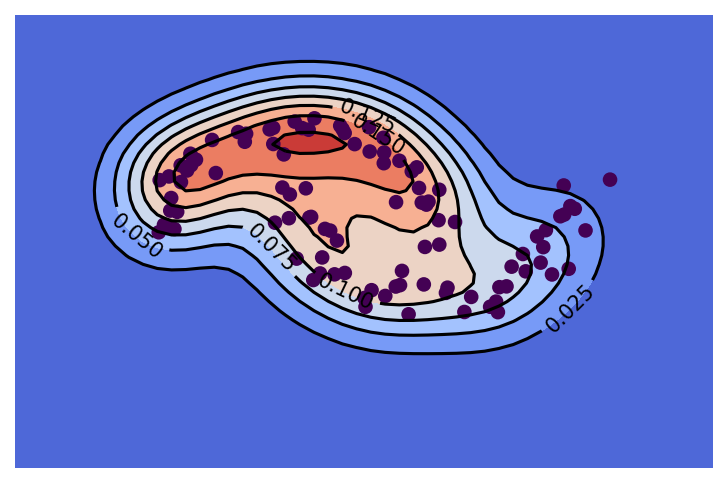

In [311]:
fig = plt.figure(dpi=150); plt.axis('off'); camera = Camera(fig)
alpha = np.ones(100)/100; l = []
for i in range(200):
    y_pred = gauss_kernel(xx, X)@alpha[:,None]
    y_pred = jnp.array(y_pred).reshape(t, t)    
    plot_density(X, xx, y_pred)
    camera.snap()
    alpha = update(alpha, X, C=0.02, eta=.04)
    l.append(loss(alpha, X))
animation = camera.animate()
HTML(animation.to_html5_video())  

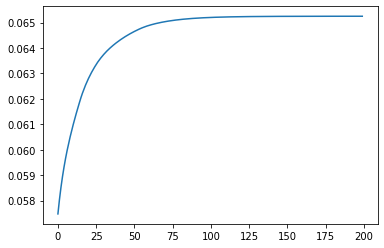

In [312]:
plt.plot(l)

# Clustering

If we have a mixture model, could we use the likelihood of each component as a categorization prediction?

Yes, but not the objective function (i.e., no competition between classes)

Better use a dedicated algorithm

## $k$-means

Categorization by approximation

Define $M$ partitions $C_k$ of the training set $\mathcal{A}$ and their associated predictor $\mu_k$

$$\min_{C_k, \mu_k} \sum_k \sum_{\mathbf{x} \in C_k} \| \mathbf{x} - \mu_k \|^2 $$

Alternate stepest descent between $C_k$ and $\mu_k$

Stepest descent on $C_k$

$$ \min_{C_k, \cup C_k = \mathcal{A}}  \sum_k \sum_{\mathbf{x} \in C_k} \| \mathbf{x} - \mu_k \|^2 $$

Attained with nearest nearbor assignment

$$ C_k = \{ \mathbf{x} \in \mathcal{A} | \mu_k = \text{argmin}_c \|\mathbf{x} - \mu_c \|^2 \} $$

Corresponds to an E step in EM with

$$ h_i^k = \mathbb{1}_{[ \mu_k = \text{argmin}_c \|\mathbf{x} - \mu_c \|^2]} $$

Stepest descent on $\mu_k$

$$\text{min}_{\mu_k} \sum_{\mathbf{x}\in C_k} \|\mathbf{x} - \mu_k \|^2 $$

Attained for the barycenter

$$\mu_k = \frac{1}{|C_k|}\sum_{\mathbf{x} \in C_k} \mathbf{x} $$

Corresponds to an M step in EM

## Kernel $k$-means

Using a kernel $k(\mathbf{x}_i, \mathbf{x}_j) = \langle \phi(\mathbf{x}_i), \phi(\mathbf{x}_j) \rangle$


$$\min_{C_k, \mu_k} \sum_k \sum_{\mathbf{x} \in C_k} \| \phi(\mathbf{x}) - \mu_k \|^2 $$

Representer theorem

$$ \mu_k = \sum_i \alpha_i \phi(\mathbf{x}_i) $$

$$ \| \phi(\mathbf{x}) - \mu_k \|^2 = k(\mathbf{x},\mathbf{x}) + \sum_{ij}\alpha_i\alpha_jk(\mathbf{x}_i, \mathbf{x}_j) - 2\sum_i\alpha_i k(\mathbf{x}, \mathbf{x_i}) $$

$C_k$ step unchanged

$\mu_k$ step, note that

$$\mu_k = \frac{1}{|C_k|}\sum_{\mathbf{x}\in C_k} \phi(\mathbf{x}) $$

Thus

\begin{align} 
\alpha_i = \begin{cases} 1/|C_k| \text{if } \mathbf{x} \in C_k \\
0, \text{else} \end{cases}
\end{align}

In [313]:
def Estep(X, mu):
    D = ((X[:,None,:] - mu[None,:,:])**2).sum(axis=2) # n x M
    return D.argmin(axis=1)
def Mstep(X, h):
    h = jax.nn.one_hot(h, num_classes=25)
    mu = (X[:,None,:]*h[:,:,None]).sum(axis=0)/(1e-5+h[:,:,None].sum(axis=0))
    return mu

In [315]:
def plot_km(X, xv, yv, y_pred, mu):
    plt.pcolormesh(xv, yv, y_pred, shading='auto', aa=True)
    plt.scatter(mu[:,0], mu[:,1], c=np.arange(25), marker='^', s=150, edgecolors='k')
    plt.scatter(X[:,0], X[:,1], c=h, edgecolors='k')

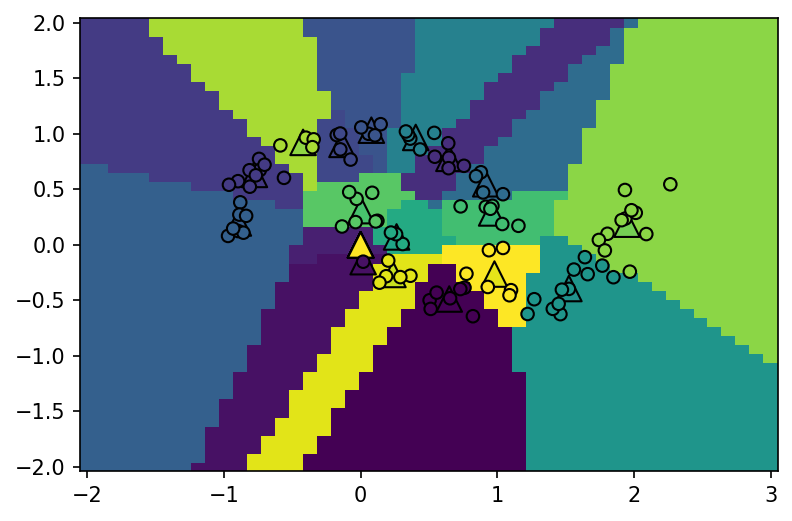

In [316]:
fig = plt.figure(dpi=150)
camera = Camera(fig)
mu = 2*np.random.random((25, 2))-0.5
for e in range(20):
    h = Estep(X, mu)
    y_pred = Estep(xx, mu)+1
    y_pred = jnp.array(y_pred).reshape(t, t)
    plot_km(X, xv, yv, y_pred, mu)
    camera.snap()
    mu = Mstep(X, h)
    plot_km(X, xv, yv, y_pred, mu)
    camera.snap()
animation = camera.animate(interval=700)
HTML(animation.to_html5_video())  

# Metric Learning

So far, we use either the *natural* distance on $\mathcal{X}$ or the one induced by the choice of a kernel

Can we just *learn* the distance?

Find transform $\phi(\cdot)$ such that

- Related samples have short distances
- Unrelated samples have larger distances

### Contrastive loss

Linear model

$$ \phi(\mathbf{x}) = \mathbf{Px} $$

Define *Positive* and *Negative* sets $\mathcal{P}(\mathbf{x}), \mathcal{N}(\mathbf{x})$ for each example $\mathbf{x}$

$$ \min_\mathbf{P} \sum_\mathbf{x} \sum_{\mathbf{x}_p \in \mathcal{P}(\mathbf{x})} \|\mathbf{Px} - \mathbf{Px}_p\|^2 - \lambda \sum_{\mathbf{x}_p \in \mathcal{N}(\mathbf{x})} \|\mathbf{Px} - \mathbf{Px}_n\|^2  $$

In practice, we don't want to put negative examples at an infinite distance

$$ \min_\mathbf{P} \sum_\mathbf{x} \sum_{\mathbf{x}_p \in \mathcal{P}(\mathbf{x})} \|\mathbf{Px} - \mathbf{Px}_p\|^2 + \lambda \sum_{\mathbf{x}_p \in \mathcal{N}(\mathbf{x})} \max(0, \beta - \|\mathbf{Px} - \mathbf{Px}_n\|^2)  $$

*Push* negative example until they are above margin $\beta$

Similar argument for the *positive* set with margin 

$$ \max(0, \|\mathbf{Px} - \mathbf{Px}_p\|^2 - \alpha) $$

## Large Margin Nearest Neighbor

Learn a distance that *enhances* a nearest neighbor classifier

- Define *positives* as elements of the $k$ nearest neighbors with the same label as $\mathbf{x}$
$$ \mathcal{P}(\mathbf{x}) = \{ \mathbf{x}_c \in k\text{NN}(\mathbf{x}) | y_c = y \}$$ 
- Define *negatives* as elements of the $k$ nearest neighbors with different labels as $\mathbf{x}$
$$ \mathcal{N}(\mathbf{x}) = \{ \mathbf{x}_c \in k\text{NN}(\mathbf{x}) | y_c \neq y \}$$

# Probably Approximately Correct

Can we obtain formal guaranties in Learning?

Formal model of learnability

- Domain set $\mathcal{X}$: observations with distribution $\mathcal{D}$
- Label set $\mathcal{Y}$: target of prediction
- Concept $f: \mathcal{X} \rightarrow \mathcal{Y}$, data generation process
- Hypothesis $h: \mathcal{X} \rightarrow \mathcal{Y}$, prediction function
- Hypothesis class $\mathcal{H} = \{ h\}$, set of hypotheses
- Error $L_{\mathcal{D}, f}(h) = Pr_{x\sim \mathcal{D}}[h(x) \neq f(x)]$

## Empirical Risk Minimization

- $\mathcal{D}$ is unknown, and so is $L_{\mathcal{D}, f}(h)$
- Training set $\mathcal{A} = \{(x_1, y_1), \dots, (x_m, y_m)\}$ sampled i.i.d from $\mathcal{D}$ and labeled with $f$
- Empirical risk: $L_\mathcal{A}(h) = \frac{1}{m}\sum_i[h(x_i) \neq y_i]$

ERM principle:

$$ h_\mathcal{A} = \text{argmin}_{h\in\mathcal{H}}L_\mathcal{A}(h)$$ 

### Realizability assumption

##### Definition (Realizability assumption): 
There exists $h^\star \in\mathcal{H}$ such that $L_{\mathcal{D}, f}(h^\star) = 0$ 

Remark that with probability 1 over a random set $\mathcal{A} = \{(x_i, y_i)\}, x_i \sim \mathcal{D}$ and $y_i = f(x_i)$, we have $L_\mathcal{A}(h^\star) = 0$

## ERM Failures?

Given the realizability assumption, what is the probability that the ERM fails?

Bounding the generalization risk

$$ Pr_\mathcal{A}[L_{\mathcal{D}, f}(h_\mathcal{A}) > \epsilon] \leq \delta$$

Probably ($\delta$) Approximately ($\epsilon$) Correct

## Generalization bound

- Bad hypotheses set

$$\mathcal{H}_B = \{h\in\mathcal{H} | L_{\mathcal{D},f}(h) > \epsilon\}$$

- Misleading training sets

$$M = \{\mathcal{A} | \exists h \in \mathcal{H}_B, L_\mathcal{A}(h) = 0 \} $$

Set of training sets that appear to be good ($L_{\mathcal{A}}(h_\mathcal{A}) = 0$) but are bad in reality ($L_{\mathcal{D}, f}(h_\mathcal{A}) > \epsilon$)

We want to know the probability that the ERM fails because we have sampled a misleading dataset

Let us construct $M$

- We follow the ERM
- We have the realizability assumption 
- Misleading training sets achieve zero empirical risk for bad classifiers

$$M = \cup_{h\in\mathcal{H}_B}\{\mathcal{A}|L_\mathcal{A}(h) = 0\} $$

Remark that 

$$ \{\mathcal{A}|L_{\mathcal{D}, f}(h_\mathcal{A}) > \epsilon\} \subseteq M $$

(a training set that leads to $\epsilon$ generalization error is necessarily a misleading training set beacuse of realizability)

Combining the two using an union bound

$$Pr_\mathcal{A}[\mathcal{A}|L_{\mathcal{D}, f}(h_\mathcal{A}) > \epsilon] \leq \sum_{h\in\mathcal{H}_B} Pr_\mathcal{A}[\mathcal{A}|L_\mathcal{A}(h) = 0] $$

Elements of $\mathcal{A}$ are sampled i.i.d

$$Pr_\mathcal{A}[\mathcal{A}|h\in\mathcal{H}_B,L_\mathcal{A}(h) = 0] = \prod_{i=1}^m Pr[h(x_i) = f(x_i)] $$

Since $h\in\mathcal{H}_B$, $Pr[h(x_i) = f(x_i)] \leq 1 - \epsilon$, thus

$$Pr_\mathcal{A}[\mathcal{A}|h\in\mathcal{H}_B,L_\mathcal{A}(h) = 0]  \leq (1-\epsilon)^m \leq e^{-\epsilon m} $$


$$Pr_\mathcal{A}[\mathcal{A}|L_{\mathcal{D},f}(h_\mathcal{A}) >\epsilon] \leq |\mathcal{H}_B|e^{-\epsilon m} \leq |\mathcal{H}|e^{-\epsilon m} $$

##### Theorem

Let $\mathcal{H}$ be a finite hypothesis class, $\delta \in [0, 1]$, $\epsilon > 0$ and $m$ such that 

$$ m\geq \frac{\log (|\mathcal{H}|/\delta)}{\epsilon} $$

Then, for any labeling function $f$, and on any distribution $\mathcal{D}$ for which the realizability assumption holds, we have for every ERM hypothesis $h_\mathcal{A}$

$$Pr_\mathcal{A}[L_{\mathcal{D}, f}(h_\mathcal{A}) \leq \epsilon] \geq 1 - \delta $$

## PAC Learning

##### Definition (PAC Learnability):
A hypothesis class $\mathcal{H}$ is PAC learnable if $\exists m_\mathcal{H}: [0,1]^2 \rightarrow \mathbb{N}$ and a learning algorithm such that $\forall \epsilon, \delta \in [0,1]^2, \forall \mathcal{D}$ over $\mathcal{X}, \forall f: \mathcal{X} \rightarrow \{0, 1\}$, if the realizability assumption holds w.r.t. $\mathcal{H, D}, f$, then running the algorithm on $m\geq m_\mathcal{H}(\epsilon, \delta)$ i.i.d. samples generated by $\mathcal{D}$ and labeled by $f$, the algorithm returns $h$ such that with probability at least $1-\delta$, $L_{\mathcal{D}, f}(h) \leq \epsilon$

##### Theorem

Every finite hypothesis class is PAC learnable with sample complexity

$$m_\mathcal{H}(\epsilon, \delta) \leq \left\lceil \frac{\log (|\mathcal{H}|/\delta)}{\epsilon} \right\rceil $$

## Fundamental theorem of PAC Learning

##### Theorem

Let $\mathcal{H}$ be a hypothesis class over $\mathcal{X} \rightarrow \{0, 1\}$ and using the 0-1 loss function, then the following are equivalent

1. $\mathcal{H}$ is PAC learnable
2. Any ERM rule is a successful PAC learner for $\mathcal{H}$
3. $\mathcal{H}$ has finite VC dimension

## No Free Lunch Theorem

##### Theorem

Let $A$ be any learning algorithm for the task of binary classification with the 0-1 loss over $\mathcal{X}$, Let $m < |\mathcal{X}|/2$ be a training set size. Then there exists a distribution over $\mathcal{X}$ and a concept $f$ such that:

1. $\exists h: \mathcal{X} \rightarrow \{0, 1\}, L_{\mathcal{D}, f}(h) = 0$ (there is a good hypothesis)
2. With probability at least 1/7 over the choice of $\mathcal{A}\sim \mathcal{D}$, we have $L_{\mathcal{D}, f}(A(\mathcal{A})) \geq 1/8$ (the algorithm does not find it)

No universal learner

# Clustering, Metric learning and PAC, take home


Unsupervised learning

- Density estimation: how likely is an example

- Clustering: partitioning $\mathcal{X}$ into arbitrarily chosen classes



- EM is a powerful algorithm for DE and clustering, but sensitive to init

- $k$-means shows up frequently as a basic tool (many improved version: splitting init, codeword shifting, etc)

- $k$-means is an excellent init for GMM


Metric learning

- ML algorithm dependent on the natural distance on $\mathcal{X}$

- can be improved by using a better kernel (metric in the induced space)

- Learning the metric can turn hard learning problem into easy ones

- $k$NN with metric learning often has a good complexity/accuracy trade-off


PAC


- Formal study of learnability without specifying the data distribution or the type of hypothesis

- Finite classes are learnable

- But bounds have unrealistic number of samples

- No universal learner: some algorithms are better at some problems than others

